# Rock Paper Scissors (using InceptionV3 network)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will build a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) model using [Tensorflow](https://www.tensorflow.org/) to recognize Rock-Paper-Scissors signs (gestures) on the photo.

Instead of training the model from scratch we will use an [InceptionV3](https://keras.io/applications/#inceptionv3) model which is pre-trained on the [ImageNet](http://www.image-net.org/) dataset, a large dataset of 1.4M images and 1000 classes of web images.

![rock_paper_scissors_cnn.jpg](../../assets/images/covers/rock_paper_scissors_cnn.jpg)

_Inspired by [Getting started with TensorFlow 2.0](https://medium.com/@himanshurawlani/getting-started-with-tensorflow-2-0-faf5428febae) article._

## Importing dependencies

In [0]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Configuring TensorBoard

In [40]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# Clear any logs from previous runs.
!rm -rf ./logs/

## Loading the dataset

In [42]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [0]:
(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name='rock_paper_scissors',
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [44]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 



In [45]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [46]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [47]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# For Mobilenet v2 possible input sizes are [96, 128, 160, 192, 224].
INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 128
Input image shape (reduced): (128, 128, 3)


Input image size: 128
Input image shape: (128, 128, 3)


In [0]:
get_label_name = dataset_info.features['label'].int2str

In [49]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


## Exploring the dataset

In [0]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

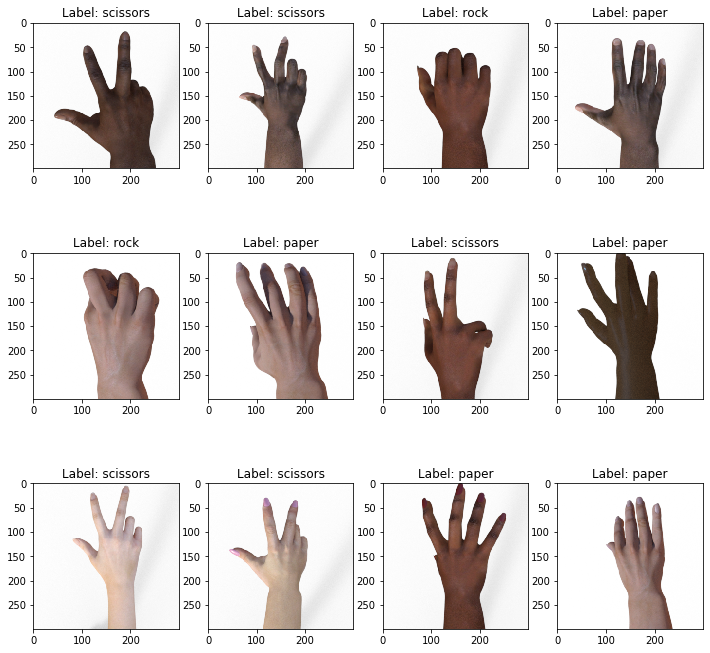

In [51]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [52]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Pre-processing the dataset

In [0]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [0]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [55]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (128, 128, 3) 

[[[0.99521387 0.99521387 0.99521387]
  [0.99607843 0.99607843 0.99607843]
  [0.9939281  0.9939281  0.9939281 ]
  ...
  [0.9838513  0.9838513  0.9838513 ]
  [0.9856216  0.9856216  0.9856216 ]
  [0.98129785 0.98129785 0.98129785]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9960181  0.9960181  0.9960181 ]
  [0.99601716 0.99601716 0.99601716]
  ...
  [0.9818407  0.9818407  0.9818407 ]
  [0.984375   0.984375   0.984375  ]
  [0.98169994 0.98169994 0.98169994]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.9953719  0.9953719  0.9953719 ]
  ...
  [0.9859232  0.9859232  0.9859232 ]
  [0.98425245 0.98425245 0.98425245]
  [0.97992975 0.97992975 0.97992975]]

 ...

 [[0.98749423 0.98749423 0.98749423]
  [0.9882133  0.9882133  0.9882133 ]
  [0.986736   0.986736   0.986736  ]
  ...
  [0.972549   0.972549   0.972549  ]
  [0.97391427 0.97391427 0.97391427]
  [0.9755237  0.9755237  0.9755237 ]]

 [[0.9907878  0.9907878  0.9907878

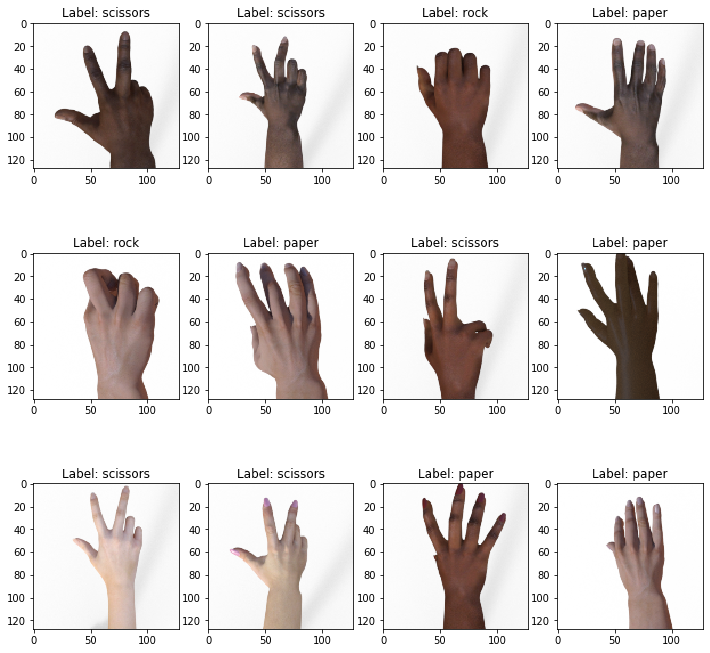

In [56]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

## Data augmentation

https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

In [0]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [0]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [0]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [0]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
  random = tf.random.uniform(shape=[], minval=0, maxval=1)
  if random > 0.5:
    image = tf.math.multiply(image, -1)
    image = tf.math.add(image, 1)
  return image

In [0]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [0]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [0]:
dataset_train_augmented = dataset_train.map(augment_data)

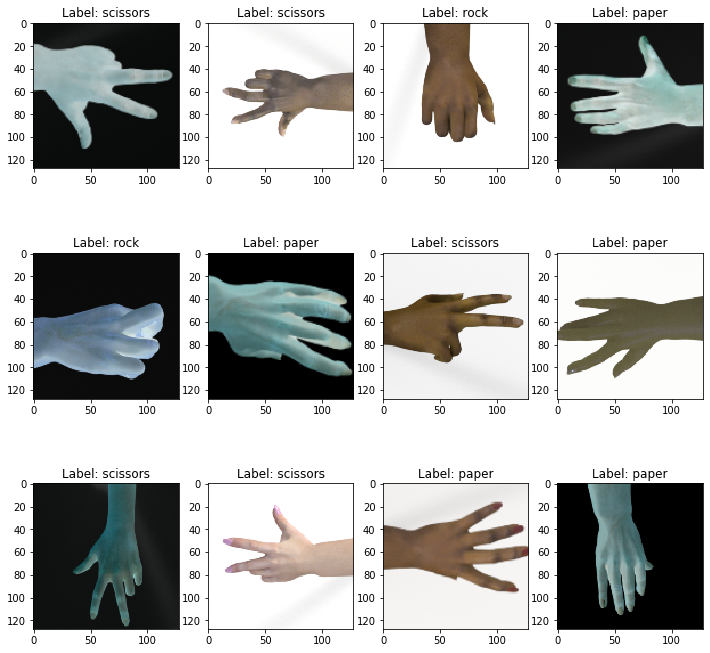

In [64]:
# Explore augmented training dataset.
preview_dataset(dataset_train_augmented)

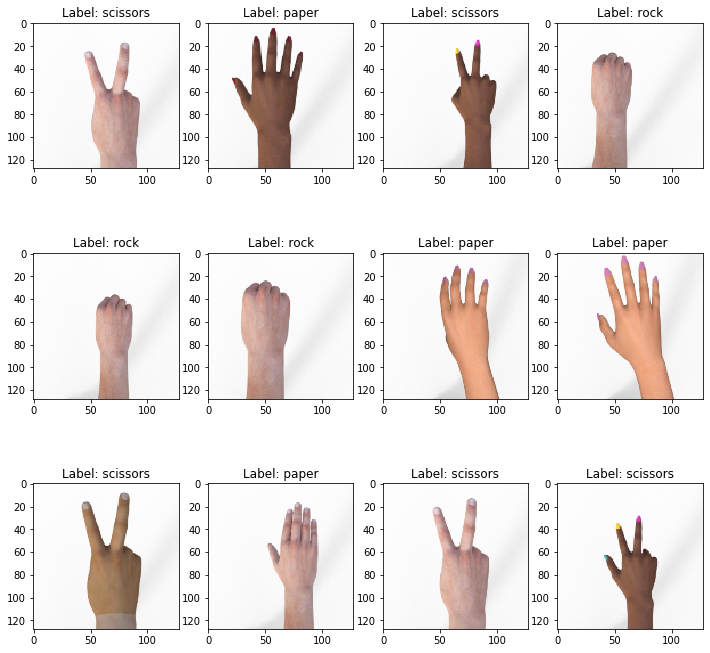

In [65]:
# Explore test dataset.
preview_dataset(dataset_test)

## Data shuffling and batching

In [0]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [67]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


Label batch shape: (32,) 

Image batch shape: (32, 128, 128, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.95550424 0.9547494  0.9543432 ]
  [0.95502657 0.95427173 0.9538655 ]
  [0.9557111  0.9549563  0.9545501 ]
  ...
  [0.9633207  0.96256584 0.96215963]
  [0.962033   0.96127814 0.96087193]
  [0.9619133  0.96115845 0.96075225]]

 [[0.95649433 0.9557395  0.9553333 ]
  [0.9566021  0.95584726 0.95544106]
  [0.9567797  0.9560249  0.9556187 ]
  ...
  [0.9632783  0.96252346 0.96211725]
  [0.9618241  0.9610693  0.9606631 ]
  [0.96200025 0.9612454  0.9608392 ]]

 [[0.9559515  0.9551967  0.9547905 ]
  [0.9569194  0.95616454 0.95575833]
  [0.956597   0.95584214 0.95543593]
  ...
  [0.96151066 0.9607558  0.9603496 ]
  [0.9625379  0.96178305 0.96137685]
  [0.9621449  0.9613901  0.9609839 ]]

 ...

 [[0.939276   0.93852115 0.9381149 ]
  [0.9379166  0.93716174 0.93675554]
  [0.9373399  0.93658507 0.93617886]
  ...
  [0.95743716 0.95668

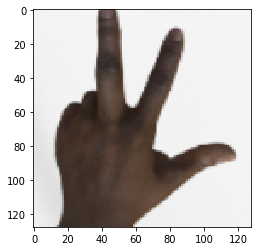

In [68]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

## Creating the model

### Loading an InceptionV3 model

We don't want to use the top classification layer of the pre-trained InceptionV3 model as it contains 1000 classes when we need only 3 (`rock`, `paper` and `scissors`). We will specify that by setting a `include_top` parameter to `False`. It will also allow us to use custom input image shape instead of a standard `(299, 299, 3)` one.

You may read more about `InceptionV3` application on [InceptionV3 Keras Documentation](https://keras.io/applications/#inceptionv3)

In [0]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='max'
)

In [0]:
# Freezing the base model since we don't want to re-train it.
# We're only interesting in its feature extraction.
base_model.trainable = False

In [93]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [94]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,
    show_layer_names=True,
)

Output hidden; open in https://colab.research.google.com to view.

### Adding a classification head

In [0]:
model = tf.keras.models.Sequential()

model.add(base_model)

# Average the features (3, 3, 2048) given by the base model
# and convert it to a single (2048) vector.
# model.add(tf.keras.layers.GlobalAveragePooling2D())

# model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Dense(
#     units=1024,
#     activation=tf.keras.activations.relu
# ))

# model.add(tf.keras.layers.Dense(
#     units=512,
#     activation=tf.keras.activations.relu
# ))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [106]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


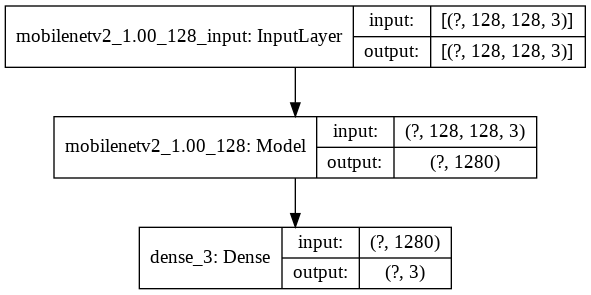

In [107]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Compiling the model

In [0]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Training the model

In [109]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [0]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [0]:
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5
)

In [102]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Train for 78 steps, validate for 11 steps
Epoch 1/15
78/78 [==============================] - 25s 321ms/step - loss: 7.4443 - accuracy: 0.6406 - val_loss: 5.1729 - val_accuracy: 0.6165
Epoch 2/15
78/78 [==============================] - 14s 183ms/step - loss: 3.1105 - accuracy: 0.7986 - val_loss: 2.7785 - val_accuracy: 0.7386
Epoch 3/15
78/78 [==============================] - 18s 227ms/step - loss: 2.5308 - accuracy: 0.8420 - val_loss: 12.8108 - val_accuracy: 0.6591
Epoch 4/15
78/78 [==============================] - 18s 228ms/step - loss: 2.3652 - accuracy: 0.8609 - val_loss: 2.6829 - val_accuracy: 0.7983
Epoch 5/15
78/78 [==============================] - 18s 230ms/step - loss: 2.3375 - accuracy: 0.8674 - val_loss: 9.5804 - val_accuracy: 0.6278
Epoch 6/15
78/78 [==============================] - 18s 229ms/step - loss: 1.8786 - accuracy: 0.8846 - val_loss: 12.6013 - val_accuracy: 0.5682
Epoch 7/15
78/78 [==============================] - 17s 223ms/step - loss: 1.9080 - accuracy: 0.90

In [0]:
def render_training_history(training_history):
  loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']

  accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  plt.figure(figsize=(14, 4))

  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(loss, label='Training set')
  plt.plot(val_loss, label='Test set')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)

  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(accuracy, label='Training set')
  plt.plot(val_accuracy, label='Test set')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)

  plt.show()

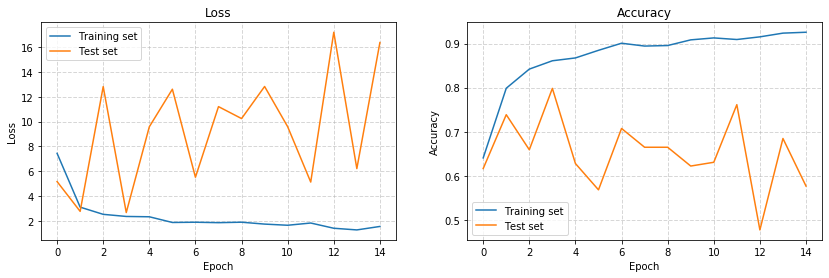

In [104]:
render_training_history(training_history)

## Model fine tuning

In [0]:
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [0]:
# Fine tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(
    optimizer = rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 11,121,027
Non-trainable params: 10,687,904
_________________________________________________________________


In [0]:
training_history_fine = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Train for 78 steps, validate for 11 steps
Epoch 1/15
 1/78 [..............................] - ETA: 15:04 - loss: 1.4011 - accuracy: 0.1875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.194587). Check your callbacks.


78/78 [==============================] - 22s 277ms/step - loss: 0.7017 - accuracy: 0.9143 - val_loss: 235.9805 - val_accuracy: 0.3352
Epoch 2/15
78/78 [==============================] - 11s 139ms/step - loss: 0.0823 - accuracy: 0.9839 - val_loss: 51.8936 - val_accuracy: 0.3920
Epoch 3/15
78/78 [==============================] - 11s 139ms/step - loss: 0.0507 - accuracy: 0.9916 - val_loss: 65.5799 - val_accuracy: 0.3608
Epoch 4/15
78/78 [==============================] - 10s 130ms/step - loss: 0.0671 - accuracy: 0.9900 - val_loss: 22.1660 - val_accuracy: 0.4545
Epoch 5/15
78/78 [==============================] - 11s 139ms/step - loss: 0.0188 - accuracy: 0.9948 - val_loss: 52.9029 - val_accuracy: 0.3466
Epoch 6/15
78/78 [==============================] - 11s 142ms/step - loss: 0.0288 - accuracy: 0.9944 - val_loss: 12.7451 - val_accuracy: 0.4602
Epoch 7/15
78/78 [==============================] - 11s 141ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 26.3142 - val_accuracy: 0.4403
Ep

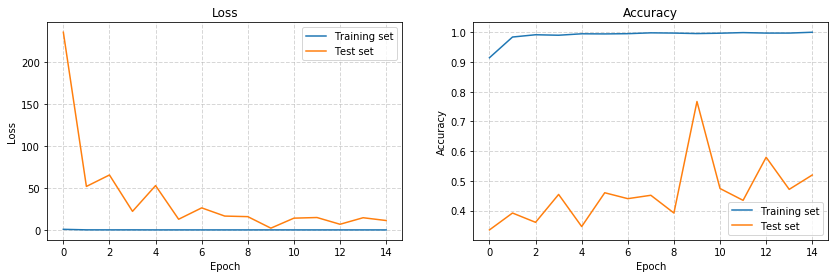

In [0]:
loss = training_history_fine.history['loss']
val_loss = training_history_fine.history['val_loss']

accuracy = training_history_fine.history['accuracy']
val_accuracy = training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## Debugging the training with TensorBoard

In [0]:
%tensorboard --logdir logs/fit

## Evaluating model accuracy

In [0]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

     12/Unknown - 3s 228ms/step - loss: 1.0125 - accuracy: 0.6747

In [0]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  1.614173853699165
Training accuracy:  0.6123016


Test loss:  1.012492597103119
Test accuracy:  0.6747312


## Saving the model

In [0]:
model_name = 'rock_paper_scissors_inception_v3.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/rock_paper_scissors_inception_v3/rock_paper_scissors_inception_v3.h5 \
  ./demos/public/models/rock_paper_scissors_inception_v3
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.